In [1]:
%load_ext autoreload
%autoreload 2

#https://mc-stan.org/docs/2_18/stan-users-guide/bayesian-measurement-error-model.html

In [2]:
# add noise to prediction

In [3]:
#from mdm.dataset import Standardization, LogTransform
RANDOM_SEED=1985

In [4]:
import pandas as pd
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano.tensor as tt

In [421]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]


In [ ]:
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

reitan_model = pm.Model()

# assume measurement error
with reitan_model:
    # Hyper params (or hyper-priors)
    m = 2 #otherwise poisson
    u_a = 2.84
    u_b = 2.46
    sigma_a = 1.38
    sigma_b = 0.92
    rho = -0.42
    break_points = m-1
    
    # Priors
    gamma = MVN
    
    
    

In [6]:
def tt_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
        
    x_std = (x - tt.mean(x_o)) / tt.std(x_o)
    return x_std


def tt_unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * tt.std(x_o) + tt.mean(x_o)
    return x

def unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * np.std(x_o) + np.mean(x_o)
    return x


def tt_log_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x)
    log_x_o = tt.log(x_o)
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std
    

def tt_log_unstandardize(x_std, x_o):

    log_x_o = tt.log(x_o) #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x)
    
def tt_standardize_stage(x, offset, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x) - offset
    log_x_o = tt.log(x_o) - offset
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std

def tt_unstandardize_stage(x_std, offset, x_o):

    log_x_o = tt.log(x_o) - offset #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x + offset)

# plotting?
def predictive_plot(ppc, q_obs, s_obs, offset=False, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    s_obs.min()
    s_min = np.floor(s_obs.min())
    s_max = np.ceil(s_obs.max())
    s_sim = np.linspace(s_min, s_max)
    
    if offset:
        o = ppc['offset']
    else:
        o = 0
      
    #predictor_scaled = tt_log_standardize(s_sim-o, s_obs-o).eval()
    #q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()
    
    #log_mu_ppq = (ppc["a"] + ppc["b"] * np.log(s_obs - o)).T
    log_mu_ppq = ppc['a'].reshape(-1,1) + ppc['b'].reshape(-1,1)*np.log((s_sim.reshape(1,-1) - ppc['offset'].reshape(-1,1)))
    log_pred_ppq = log_mu_ppq + ppc['sigma'].reshape(-1,1) * pm.Normal.dist(0,1).random(size=(4000,50))
    
    mu_ppq = np.exp(log_mu_ppq)
    pred_ppq = np.exp(log_pred_ppq)
    
    
    
    #plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')
    
    ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');
    
    ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)
    
    
    az.plot_hdi(
        s_sim,
        pred_ppq,
        ax=ax,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
    )
    
    
    ax.set_xlabel("Stage (feet)")
    ax.set_ylabel("Discharge (ft3/s)")
    
    ax.legend(ncol=2, fontsize=10)

In [175]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]


In [431]:
s_obs.min()

2.21

In [429]:
# not working cn't debug
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    #segments = 
    segments = 2
    
    # XXX testing with scale factors to keep things in bounds
    b0 = pm.Uniform('b0', 0.0, s_obs.min()*0.9 )
    bj = pm.Uniform('bj', s_obs.min()*1.01, s_obs.max()*0.9)
    #b0 = pm.Uniform('b0', 0.0, s_obs.min() )
    #bj = pm.Uniform('bj', s_obs.min(), s_obs.max())
    b = tt.stack([b0, bj])
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    #c = pm.Normal("c", mu=2.08, sigma=4, shape=segments) #XXX mush too loose
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    i = pm.math.switch(s_obs >= b[1], 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)

In [430]:
map_estimate = pm.find_MAP(model=stage_model)
map_estimate

{'b0_interval__': array(0.39739449),
 'bj_interval__': array(-1.59170314),
 'a': array([7.33171535, 8.20833397]),
 'c': array([1.53178926, 1.86095762]),
 'sigma_log__': array(0.23253037),
 'b0': array(1.18954432),
 'bj': array(3.730026),
 'sigma': array(1.26178876)}

In [281]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.99) #failed at 95

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, a, bj]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 212 seconds.
There were 597 divergences after tuning. Increase `target_accept` or reparameterize.
There were 528 divergences after tuning. Increase `target_accept` or reparameterize.
There were 733 divergences after tuning. Increase `target_accept` or reparameterize.
There were 688 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [353]:
x = []
x.append('s')
x

['s']

In [425]:
# MAP with known number of segments
#
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors

    segments = 2

    b_list = []
    b0 = pm.Uniform('b0', 0.0, s_obs.min())
    b_list.append(b0)
    for j in range(1,segments):
        b_list.append(pm.Uniform('b_{}'.format(j), s_obs.min(), s_obs.max()))
    b = tt.stack(b_list)   
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    #c = pm.Normal("c", mu=2.08, sigma=4, shape=segments) #XXX mush too loose
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    # replace loop with theano scan
    i = tt.zeros(n, dtype='int32')
    for j in range(1, segments):
        i = i + pm.math.switch(s_obs >= b[j], 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)

In [426]:
map_estimate = pm.find_MAP(model=stage_model, maxeval=5000)
map_estimate

{'b0_interval__': array(0.54739258),
 'b_1_interval__': array(-0.08906776),
 'a': array([7.1191532 , 8.07810656]),
 'c': array([1.48481843, 1.84486558]),
 'sigma_log__': array(-0.99968052),
 'b0': array(1.40010227),
 'b_1': array(7.04002995),
 'sigma': array(0.36799699)}

In [405]:
pm.find_MAP?

Signature:
pm.find_MAP(
    start=None,
    vars=None,
    method='L-BFGS-B',
    return_raw=False,
    include_transformed=True,
    progressbar=True,
    maxeval=5000,
    model=None,
    *args,
    **kwargs,
)
Docstring:
Finds the local maximum a posteriori point given a model.

find_MAP should not be used to initialize the NUTS sampler. Simply call pymc3.sample() and it will automatically initialize NUTS in a better way.

Parameters
----------
start: `dict` of parameter values (Defaults to `model.test_point`)
vars: list
    List of variables to optimize and set to optimum (Defaults to all continuous).
method: string or callable
    Optimization algorithm (Defaults to 'L-BFGS-B' unless
    discrete variables are specified in `vars`, then
    `Powell` which will perform better).  For instructions on use of a callable,
    refer to SciPy's documentation of `optimize.minimize`.
return_raw: bool
    Whether to return the full output of scipy.optimize.minimize (Defaults to `False`)
inclu

In [369]:
# MAP with multiple segments can it work with more segments?
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    #segments = 
    segments = 2
    segments = pm.DiscreteUniform('segments',1, 3)
    # XXX testing with scale factors to keep things in bounds
    b_list = []
    b0 = pm.Uniform('b0', 0.0, s_obs.min()*0.9)
    b_list.append(b0)
    for j in range(1,3):
        b_list.append(pm.Uniform('b_{}'.format(j), s_obs.min()*1.01, s_obs.max()*0.9 ))
    b = tt.stack(b_list)   
    #bj = pm.Uniform('bj', s_obs.min()*1.01, s_obs.max()*0.9)
    #bj2 = pm.Uniform('bj2', s_obs.min()*1.01, s_obs.max()*0.9)
    #b = tt.stack([b0, bj, bj2], axis=0)
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=10)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=10)
    #c = pm.Normal("c", mu=2.08, sigma=4, shape=segments) #XXX mush too loose
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    # loop and build this up by adding 
    # replace loop with theano scan
    i = tt.zeros(n, dtype='int32')
    #for j in range(1, segments):
    for j in range(1, 3):
        #if j <= segments:
        i = i + pm.math.switch(s_obs >= b[j], 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)

In [370]:
map_estimate = pm.find_MAP(model=stage_model)
map_estimate

{'segments': array(2, dtype=int64),
 'b0_interval__': array(0.28077527),
 'b_1_interval__': array(-2.22044605e-16),
 'b_2_interval__': array(-0.46814129),
 'a': array([7.57307118, 8.18187369, 8.18966092, 8.18187369, 8.18187369,
        8.18187369, 8.18187369, 8.18187369, 8.18187369, 8.18187369]),
 'c': array([1.63632445, 2.08      , 1.99069809, 2.08      , 2.08      ,
        2.08      , 2.08      , 2.08      , 2.08      , 2.08      ]),
 'sigma_log__': array(0.27621136),
 'b0': array(1.13320546),
 'b_1': array(6.66005),
 'b_2': array(5.64211982),
 'sigma': array(1.31812644)}

In [346]:
# can it work with more segments?
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    #segments = 
    segments = 2
    
    # XXX testing with scale factors to keep things in bounds
    b0 = pm.Uniform('b0', 0.0, s_obs.min()*0.9, shape=1, testval=0.1)
    bj = pm.Uniform('bj', s_obs.min(), s_obs.max()*0.9, shape=1, testval=s_obs.min())
    #bj2 = pm.Uniform('bj2', s_obs.min()*1.01, s_obs.max()*0.9)
    b = tt.stack([b0, bj], axis=0)
    #b = pm.Uniform('b', 0.1, s_obs.max(), shape=segments, testval=4)
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    #c = pm.Normal("c", mu=2.08, sigma=4, shape=segments) #XXX mush too loose
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    i = pm.math.switch(s_obs >= b[1], 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)

In [347]:
map_estimate = pm.find_MAP(model=stage_model)
map_estimate

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'b0_interval__': array([-2.93863268]), 'bj_interval__': array([-inf]), 'a': array([8.18187369, 8.18187369]), 'c': array([2.08, 2.08]), 'sigma_log__': array(-0.47015407)}

Initial evaluation results:
b0_interval__   -3.04
bj_interval__     NaN
a               -3.55
c                0.57
sigma_log__     -0.77
q                -inf
Name: Log-probability of test_point, dtype: float64

In [273]:
# XXX TOH continue here
# this does not work (go to next model)
# check if it works with c term: no
# check if it works with less informative prior:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    c = pm.Normal("c", mu=slope_u, sigma=slope_u)
    #c = pm.Normal("c", mu=2.08, sigma=0.3) #informative prior
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b = pm.Uniform('b', 0, s_obs.min())
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + c* tt.log(s_obs - b)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [274]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, c, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 124 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [270]:
# but this does work
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_true - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q = pm.Lognormal("q",
                 mu=mu,
                 sigma=sigma,
                 observed=q_true)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [272]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 115 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [263]:
# for some reason this works?!
# added segments and still okay
# changes
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    segments=1
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b0 = pm.Uniform('b0', 0, s_obs.min())
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + c * tt.log(s_obs - b0)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [264]:
with stage_model:
    stage_trace = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, sigma, c, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6741985251411853, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7069315921283982, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712518477880738, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samplin

In [246]:
# now set it up for 2 segments, but broken. why!?
from theano import tensor as tt
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    segments = 2
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b0 = pm.Uniform('b0', 0, s_obs.min()*0.9)
    bj = pm.Uniform('bj', s_obs.min()*1.1, s_obs.max()*0.9)
    
    b = tt.stack([b0, bj])

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #create index
    i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    #i = pm.math.switch(s_obs >= b[1], 1, 0)

    # Process model
    #mu = a + b * lg_s #worked without offset
    #mu = a + b * tt.log(s_obs - b)
    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [247]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bj, b0, sigma, c, a]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 85 seconds.
There were 607 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36370202742084135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 656 divergences after tuning. Increase `target_accept` or reparameterize.
There were 769 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [251]:
# now we regress to test
from theano import tensor as tt
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors
    segments = 1
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)# shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3)#, shape=segments)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b0 = pm.Uniform('b0', 0, s_obs.min())
    #bj = pm.Uniform('bj', s_obs.min(), s_obs.max())
    
    #b = tt.stack([b0, bj])

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    #i = pm.math.switch(s_obs >= b[1], 1, 0)

    # Process model
    #mu = a + b * lg_s #worked without offset
    #mu = a + b * tt.log(s_obs - b)
    mu = a + c * tt.log(s_obs - b0)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [252]:
with stage_model:
    stage_trace = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, sigma, c, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5271268001985348, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# comment out segments

# Scratch

In [192]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 64 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6697239998834084, but should be close to 0.8. Try to increase the number of tuning steps.


<ipython-input-235-ded402342637>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(stage_trace)


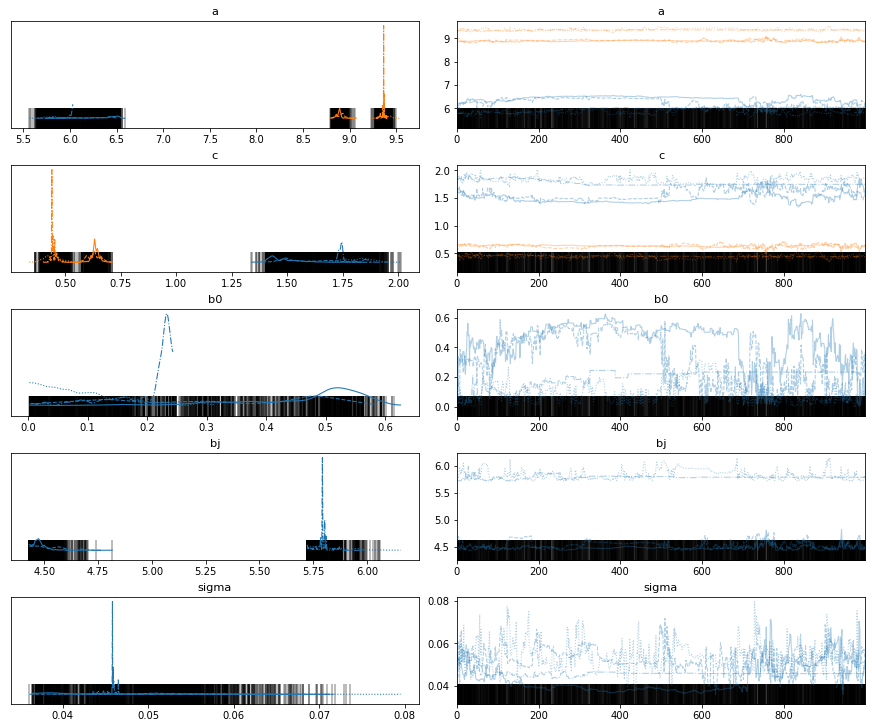

In [235]:
with stage_model:
    pm.traceplot(stage_trace)

In [236]:
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()
slope_u = lg_q_s/lg_s_s
lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors

    segments = 1

    b0 = pm.Uniform('b0', 0.0, s_obs.min())
    #bj = pm.Uniform('bj', s_obs.min(), s_obs.max())
    #b0 = 1.0
    #bj = 5.0
    #b = tt.stack([b0, bj])
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    #c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    #i = pm.math.switch(s_obs >= b0, 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a + c * tt.log(s_obs - b0)
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)

In [237]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, a, b0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 80 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7205388539781458, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46381577241549304, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7110330412365001, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples i

<ipython-input-227-afc5b7c0e5bd>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(stage_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

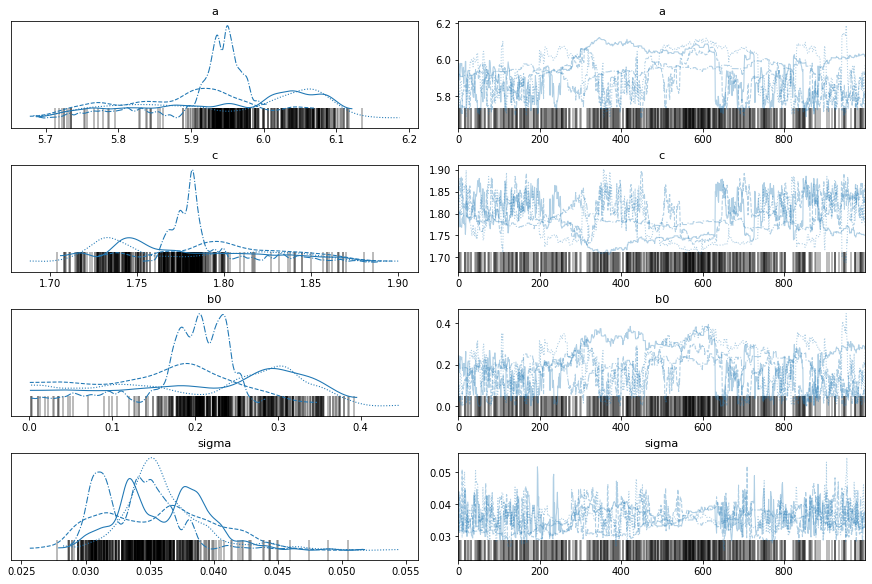

In [227]:
pm.traceplot(stage_trace)

<ipython-input-223-afc5b7c0e5bd>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(stage_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

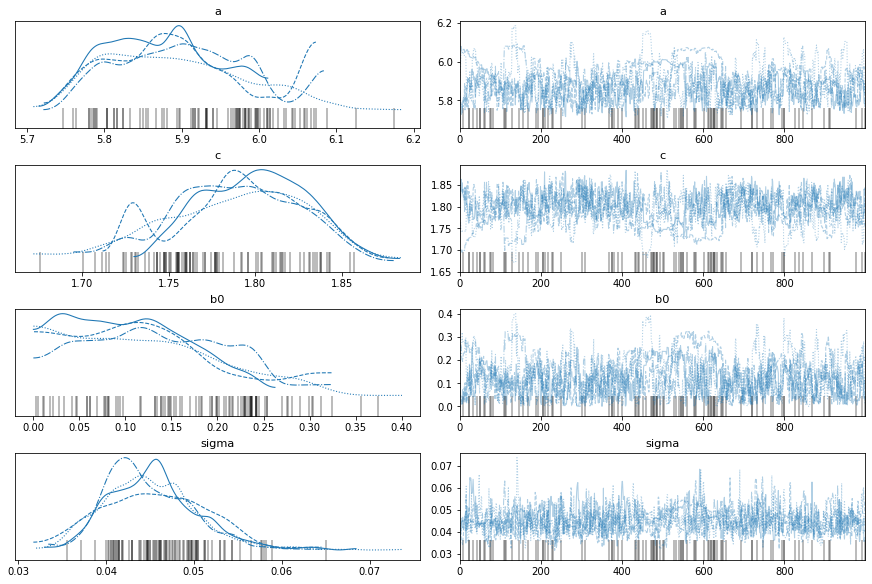

In [223]:
#pm.traceplot(stage_trace)

In [156]:
with stage_model:
    stage_trace = pm.sample(1000, tune=2000, return_inferencedata=False)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'b0_interval__': array(0.), 'bj_interval__': array(2.22044605e-16), 'a': array([8.18187369, 8.18187369]), 'c': array([2.08, 2.08]), 'sigma_log__': array(-0.47015407)}

Initial evaluation results:
b0_interval__   -1.39
bj_interval__   -1.39
a               -3.55
c                0.57
sigma_log__     -0.77
q                 NaN
Name: Log-probability of test_point, dtype: float64

In [220]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    #b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    b = pm.Normal("b", mu=2.08, sigma=0.3)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    #offset = pm.Uniform('offset', 0, offset_max)
    offset = pm.Uniform('offset', 0, s_obs.min())
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [221]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 114 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


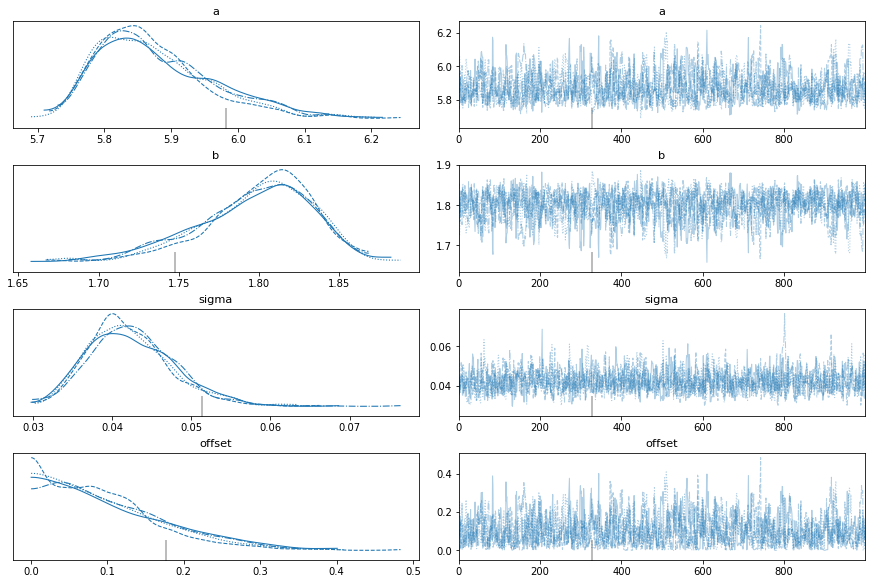

In [222]:
with error_model:
    pm.plot_trace(error_trace)

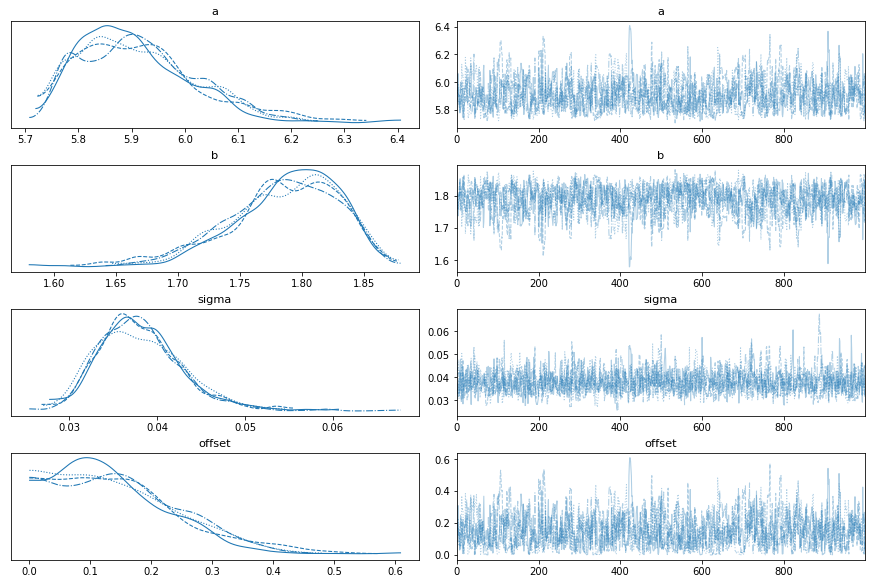

In [211]:
with error_model:
    pm.plot_trace(error_trace)

In [124]:
b0 = s_obs.min()-0.01
bj = 10
b = np.stack([b0,bj])

In [125]:
i = tt.switch(tt.gt(s_obs, b[1]), 1, 0).eval()

In [126]:
s_obs - b[i]

array([4.84, 2.23, 0.79, 0.74, 0.76, 0.89, 0.26, 0.34, 0.66, 1.33, 7.4 ,
       3.38, 0.01, 0.97, 0.89, 0.3 , 0.45, 0.78, 0.83, 4.4 , 1.72, 0.73,
       0.72, 1.52, 1.3 , 1.53, 0.92, 1.46, 6.79, 4.83, 3.52, 1.07, 0.81,
       0.29, 0.24, 2.32])

In [32]:
with stage
# Priors
    #T = pm.Uniform('changepoint', s_obs.min(), s_min.max())
    #C = pm.Uniform('control', 2, 4)
    #a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    #b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=n_control)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=n_control)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    C = pm.Uniform('control', offset, s_min.max())
    #C = pm.Uniform('control', s_obs.min(), s_min.max())
    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #control = (s_true > C) * 1
    #mu = a + b * tt.log(s_true - offset)
    mu = a[s>C] + b[s>C] * tt.log(s_true - offset)
    y = pm.Lognormal("q", mu=mu[control], sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",

array([ 7.05137159,  4.45126273,  2.97619011,  2.94795587,  2.98818689,
        3.0959931 ,  2.48598129,  2.54555444,  2.86984736,  3.52502991,
        9.61967785,  5.58523597,  2.18609978,  3.17260596,  3.10270089,
        2.51154125,  2.64108539,  3.01015045,  3.02630937,  6.58545712,
        3.91864606,  2.95869745,  2.93567225,  3.72048192,  3.47247504,
        3.74480505,  3.15258784,  3.68680527,  8.97984913,  7.03156805,
        5.70994176,  3.26699527,  3.02049885,  2.47314812,  2.4415783 ,
       12.29330245])

In [36]:
tt.switch(tt.gt(s,10), 1, 0).eval()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int8)

In [ ]:
with stage_model:
    stage_trace = pm.sample(1000, tune=1000, return_inferencedata=False, target_accept=0.95)

In [72]:
b = np.array((5,6))
i = tt.switch(tt.gt(s,b[1]), 1, 0).eval()
s_obs - b[i]

array([ 1.04, -0.57, -2.01, -2.06, -2.04, -1.91, -2.54, -2.46, -2.14,
       -1.47,  3.6 ,  0.58, -2.79, -1.83, -1.91, -2.5 , -2.35, -2.02,
       -1.97,  0.6 , -1.08, -2.07, -2.08, -1.28, -1.5 , -1.27, -1.88,
       -1.34,  2.99,  1.03,  0.72, -1.73, -1.99, -2.51, -2.56,  6.32])

In [63]:
#s_obs

i

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], dtype=int8)

In [59]:
with stage_model:
    stage_trace = pm.sample(1000, tune=1000, return_inferencedata=False, target_accept=0.95)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'b_interval__': array([0., 0.]), 'c': array([2.08, 2.08]), 'a': array([8.18187369, 8.18187369]), 'sigma_log__': array(-0.47015407)}

Initial evaluation results:
b_interval__   -2.77
c               0.57
a              -3.55
sigma_log__    -0.77
q                NaN
Name: Log-probability of test_point, dtype: float64

<ipython-input-56-afc5b7c0e5bd>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(stage_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

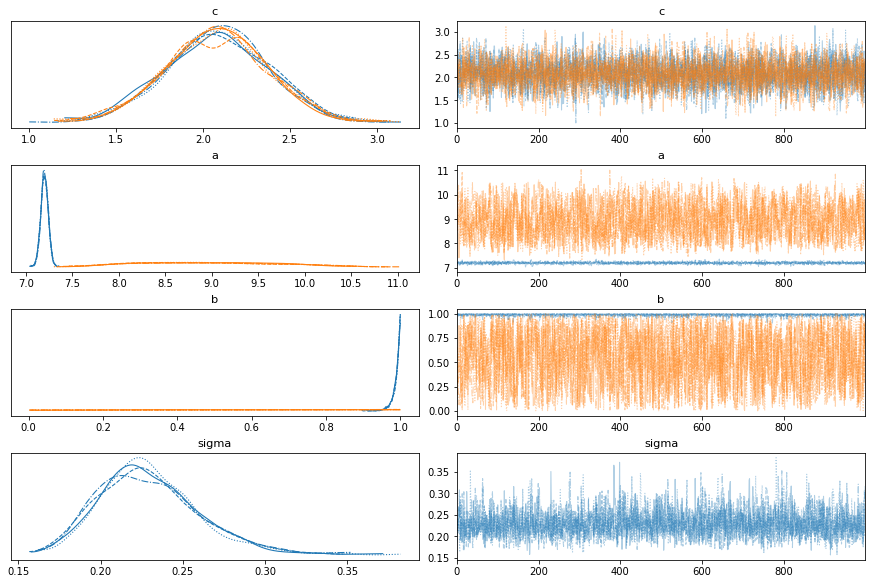

In [56]:
pm.traceplot(stage_trace)

In [57]:
s_obs

array([ 7.04,  4.43,  2.99,  2.94,  2.96,  3.09,  2.46,  2.54,  2.86,
        3.53,  9.6 ,  5.58,  2.21,  3.17,  3.09,  2.5 ,  2.65,  2.98,
        3.03,  6.6 ,  3.92,  2.93,  2.92,  3.72,  3.5 ,  3.73,  3.12,
        3.66,  8.99,  7.03,  5.72,  3.27,  3.01,  2.49,  2.44, 12.32])

In [83]:
# single changepoint
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    #T = pm.Uniform('changepoint', s_obs.min(), s_min.max())
    #C = pm.Uniform('control', 2, 4)
    #a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    #b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=n_control)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=n_control)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    C = pm.Uniform('control', offset, s_min.max())
    #C = pm.Uniform('control', s_obs.min(), s_min.max())
    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #control = (s_true > C) * 1
    #mu = a + b * tt.log(s_true - offset)
    mu = a[s>C] + b[s>C] * tt.log(s_true - offset)
    y = pm.Lognormal("q", mu=mu[control], sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu[control],
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 36

In [18]:
import theano.tensor as tt

In [26]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values.reshape(-1,1)
s_obs = df['stage'].values.reshape(-1,1)

q_sigma = df['q_sigma'].values.reshape(-1,1)
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [ ]:
# Example 1
# https://cscherrer.github.io/post/bayesian-changepoint/
import PyMC3 as pm

mod = pm.Model()
with mod:
    T = pm.Uniform('changepoint', 1860, 1960)    
    μ = pm.HalfNormal('μ', sd=4, shape=2)
    grp = (coal['date'].values > T) * 1
    y_obs = pm.Normal('y_obs', mu=μ[grp], observed = coal['count'].values)

In [50]:
b = np.ones((2,1))
#(b*s_obs).shape
s_obs*b.T + b.T

array([[ 8.04,  8.04],
       [ 5.43,  5.43],
       [ 3.99,  3.99],
       [ 3.94,  3.94],
       [ 3.96,  3.96],
       [ 4.09,  4.09],
       [ 3.46,  3.46],
       [ 3.54,  3.54],
       [ 3.86,  3.86],
       [ 4.53,  4.53],
       [10.6 , 10.6 ],
       [ 6.58,  6.58],
       [ 3.21,  3.21],
       [ 4.17,  4.17],
       [ 4.09,  4.09],
       [ 3.5 ,  3.5 ],
       [ 3.65,  3.65],
       [ 3.98,  3.98],
       [ 4.03,  4.03],
       [ 7.6 ,  7.6 ],
       [ 4.92,  4.92],
       [ 3.93,  3.93],
       [ 3.92,  3.92],
       [ 4.72,  4.72],
       [ 4.5 ,  4.5 ],
       [ 4.73,  4.73],
       [ 4.12,  4.12],
       [ 4.66,  4.66],
       [ 9.99,  9.99],
       [ 8.03,  8.03],
       [ 6.72,  6.72],
       [ 4.27,  4.27],
       [ 4.01,  4.01],
       [ 3.49,  3.49],
       [ 3.44,  3.44],
       [13.32, 13.32]])

In [57]:
C = pm.Uniform.dist(2, 4)
a = pm.Normal.dist(mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
b = pm.Normal.dist(mu=slope_u, sigma=slope_u, shape=(2,1))

q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)

mu = a + tt.log(s_true - offset) * b

TypeError: unsupported operand type(s) for *: 'TensorVariable' and 'Normal'

In [76]:
b = np.ones((2,1))

In [78]:
# single changepoint
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    #T = pm.Uniform('changepoint', s_obs.min(), s_min.max())
    C = pm.Uniform('control', 2, 4)
    #a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    #b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)


    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    control = (s_true > C) * 1
    #mu = a + b * tt.log(s_true - offset)
    mu = a + b * tt.log(s_true - offset)
    y = pm.Lognormal("q", mu=mu[control], sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu[control],
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

ValueError: Input dimension mis-match. (input[0].shape[0] = 2, input[1].shape[0] = 36)

In [ ]:
# slice sampling
with error_model:
    step =  pm.Slice()
    #trace = pm.sample(step=step)
    error_trace = pm.sample(1000, tune=2000, step=step, return_inferencedata=False)


In [ ]:
pm.traceplot(error_trace)

In [ ]:
# single changepoint
lg_q = np.log(q_obs).reshape(-1,1)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    T = pm.Uniform('changepoint', lg_q.min(), lg_q.max())
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)


    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    control = (lg_q > T) * 1
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu[control],
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [45]:
# slice sampling
with error_model:
    step =  pm.Slice()
    #trace = pm.sample(step=step)
    error_trace = pm.sample(1000, tune=2000, step=step, return_inferencedata=False)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","changepoint","offset", "q_log"], random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [offset]
>Slice: [sigma]
>Slice: [b]
>Slice: [a]
>Slice: [changepoint]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 324 seconds.
The number of effective samples is smaller than 10% for some parameters.


<ipython-input-46-307171b1fec8>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(error_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'changepoint'}>,
        <AxesSubplot:title={'center':'changepoint'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'offset'}>,
        <AxesSubplot:title={'center':'offset'}>]], dtype=object)

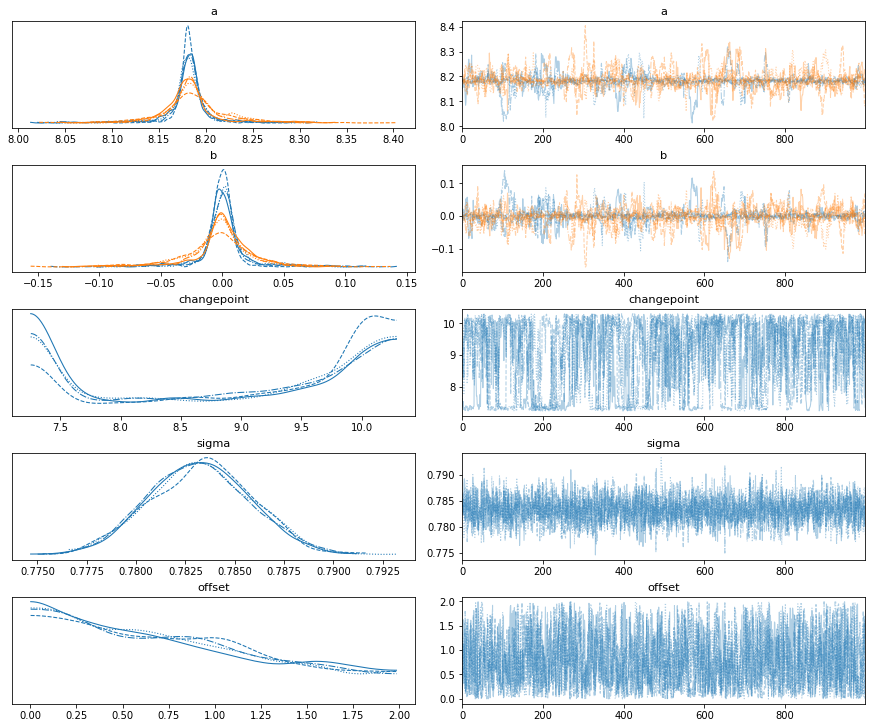

In [46]:
pm.traceplot(error_trace)

In [11]:
# default sampling
with error_model:
    error_trace = pm.sample(1000, tune=1000, return_inferencedata=False, target_accept=0.95)
    #ppc = pm.sample_posterior_predictive(
    #    error_trace, var_names=["a", "b", "sigma","changepoint","offset", "q_log"], random_seed=RANDOM_SEED
    #)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a, changepoint]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2548 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-12-307171b1fec8>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(error_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'changepoint'}>,
        <AxesSubplot:title={'center':'changepoint'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'offset'}>,
        <AxesSubplot:title={'center':'offset'}>]], dtype=object)

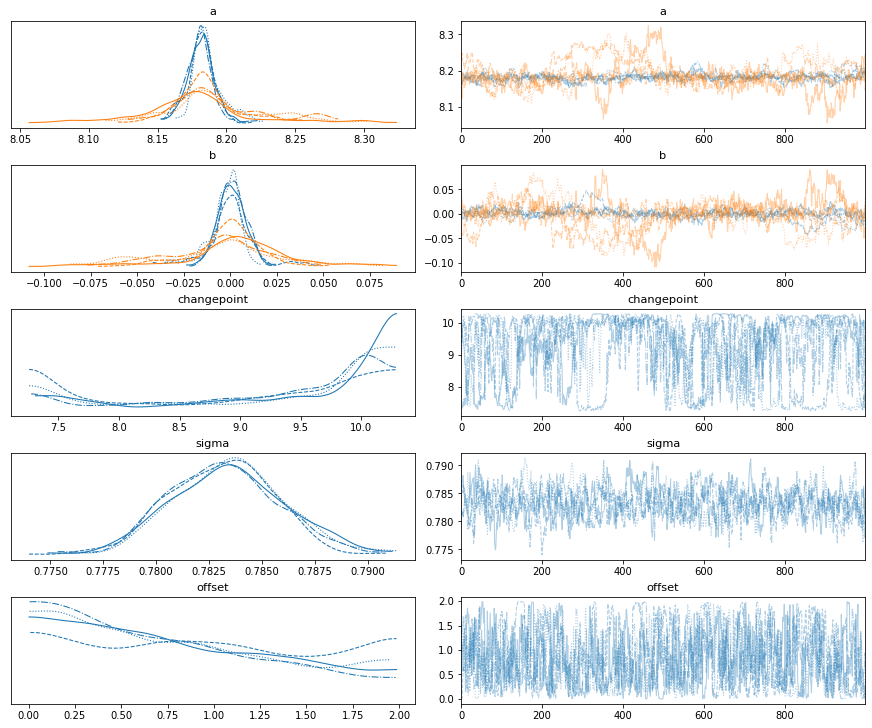

In [12]:
pm.traceplot(error_trace)

In [ ]:
# single changepoint
lg_q = np.log(q_obs).reshape(-1,1)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    T = pm.Uniform('changepoint', lg_q.min(), lg_q.max())
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=(2,1))
    b = pm.Normal("b", mu=slope_u, sigma=slope_u, shape=(2,1))
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)


    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    


    # Process model
    rate = pm.math.switch(T >= log_q, a[0], )
    control = (lg_q > T) * 1
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu[control],
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


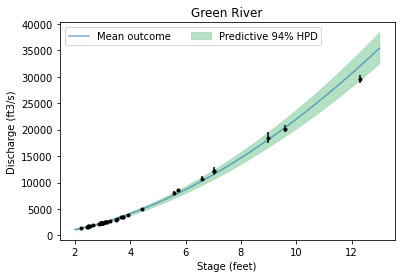

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Green River")
fig.savefig("../figures/green_channel.pdf")

In [20]:
output=pd.DataFrame()

In [21]:
site = 'Green River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

#log_q = np.log(q_obs)
#log_s = np.log(s_obs-offset)
#a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
#b_s = b*log_q.std()/log_s.std()
#sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma)**1.96

results = pd.Series({'a':a,'b':b, 'offset':offset, 'sigma':sigma, 'gerr95':gerr95}, name=site)
output = output.append(results)

In [22]:
output

,a,b,gerr95,offset,sigma
Green River,5.904799,1.788791,1.076985,0.141161,0.03784


# Scratch